In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
#columns and dtypes
df.info()

#numerical data summary
print(df.describe(exclude = 'object'))

#categorical data summary
print(df.describe(exclude = ['float', 'int64']))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.2

All of the above values will aid us in getting some sense of the how the datapoints are distributed for each column and what data types are involved.

In [ ]:
#looking at null values for columns
print(df.isnull().sum())
print(' ')
print(df.value_counts())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64
 
id     gender  age   hypertension  heart_disease  ever_married  work_type      Residence_type  avg_glucose_level  bmi   smoking_status   stroke
77     Female  13.0  0             0              No            children       Rural           85.81              18.6  Unknown          0         1
49605  Male    63.0  0             0              Yes           Private        Urban           74.39              31.0  formerly smoked  0         1
49661  Male    53.0  0             0              Yes           Govt_job       Urban           85.17              29.2  never smoked     0         1
49646  Male    72.0  0             1              Yes           Self-employed  Rural          

Some initial observations:
>From the above, we can notice that our data is relatively clean and bmi is the only column with null values and our smoking_status column contains an 'unknown' value.
- We will imputate the bmi missing values.
- We will also imputate the unknown values.

> We contain integer, float, and object data types throughout the dataset that we will need to work with. These are as follows:
- Categorical: ever_married, gender, smoking_status, work_type, Residence_type
- Binary Numerical: stroke, heart_disease, hypertension
- Continuous Numerical: avg_glucose_level, bmi, age

##**Some Preprocessing**


In [ ]:
#imputating nan bmi values
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

#verification that na values were filled
print(df.isnull().sum())

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [ ]:
print(df['smoking_status'].value_counts())
df['smoking_status'].replace('Unknown', np.nan, inplace=True)
mode_smoking = df['smoking_status'].mode()[0]
df['smoking_status'].fillna(mode_smoking, inplace = True)
print(df['smoking_status'].value_counts())

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64
smoking_status
never smoked       3436
formerly smoked     885
smokes              789
Name: count, dtype: int64


##**Chi-Squared Test**

We will now conduct a chi-squared test to determine if there is an association between the smoking status of a person and the instance of a stroke.

Our hypotheses for our test are as follows:

> **H0 (Null Hypothesis):** Smoking status and stroke instances are independent of each other and don't impact one another.

> **HA (Alternative Hypothesis):** Smoking status and stroke instance impact one another and there is an association present between them.

> We will use alpha = 0.05

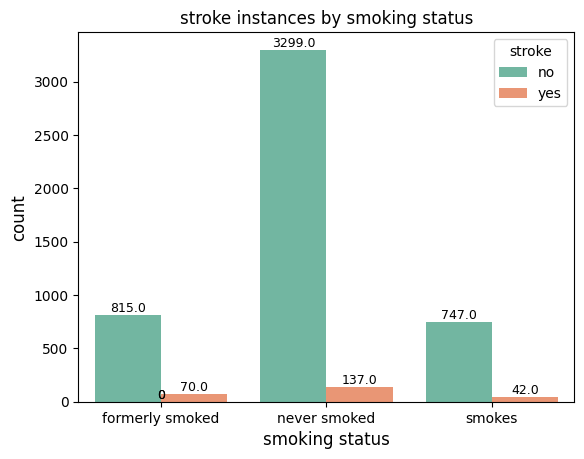

 
stroke              0    1
smoking_status            
formerly smoked   815   70
never smoked     3299  137
smokes            747   42
 
p-value is:  6.905788734861923e-06


In [ ]:
#visualizing smoking status and stroke occurrence
ax = sns.countplot(x = 'smoking_status', hue = 'stroke', data = df, palette = 'Set2')
#data labels
for p in ax.patches:
    height = p.get_height()
    ax.annotate(height,
                (p.get_x() + p.get_width() / 2., height),
                ha = 'center', va = 'bottom', fontsize = 9)
plt.title('stroke instances by smoking status', fontsize = 12)
plt.xlabel('smoking status', fontsize = 12)
plt.ylabel('count', fontsize = 12)
plt.legend(title = 'stroke', labels = ['no', 'yes'])
plt.show()

#creating contingency table and conducting a chi squared test
conti_table = pd.crosstab(df['smoking_status'], df['stroke'])
print(' ')
print(conti_table)
chi2, p, dof, expected = chi2_contingency(conti_table)
print(' ')
print('p-value is: ', p)

> Since our p-value printed above is less than 0.05, we will reject the null hypothesis and say that smoking status is associated with stroke instances as shown by our chi-squared test.





##**T-Test**
We will now conduct a T-test test to determine  if there is an association between the BMI of a person and them getting a stroke.

Our hypotheses for our test:

> **H0** (Null Hypothesis): The mean BMI for individuals who had a stroke is the same as the mean BMI for individuals who did not have a stroke.

> **HA** (Alternative Hypothesis): The mean BMI for individuals who had a stroke is different from the mean BMI for individuals who did not have a stroke.

>We will use α = 0.05 for this test.


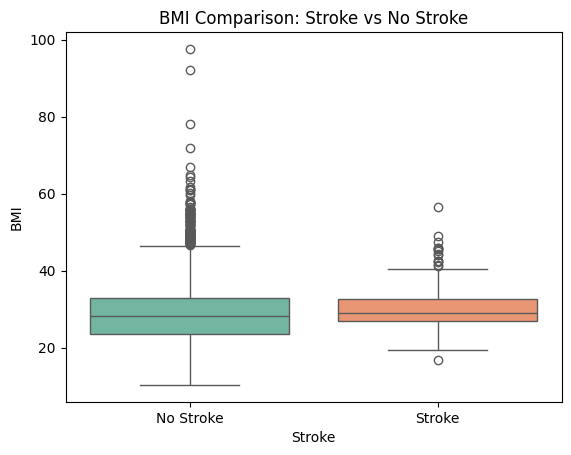

T-statistic: 2.785637387412078, P-value: 0.005361957129403666


In [ ]:
stroke_bmi = df[df['stroke'] == 1]['bmi']
no_stroke_bmi = df[df['stroke'] == 0]['bmi']

t_stat, p_value = stats.ttest_ind(stroke_bmi, no_stroke_bmi)

sns.boxplot(x = 'stroke', y = 'bmi', data = df, palette = 'Set2')
plt.title('BMI Comparison: Stroke vs No Stroke')
plt.xlabel('Stroke')
plt.ylabel('BMI')
plt.xticks([0, 1], ['No Stroke', 'Stroke'])
plt.show()

print(f"T-statistic: {t_stat}, P-value: {p_value}")

> From the results we see that p-value is 0.005361957129403666 which is less than our alpha of 0.05.

> Since our p-value is less than 0.05, we will reject the null hypothesis and say that there is a statistically significant difference in the mean BMI between individuals who had a stroke and those who did not. This suggests the there is a significant difference in the BMI values of individuals who experienced a stroke and those who did not.



##**ANOVA Test**

We will now conduct an ANOVA Test to determine if there is a statistically significant difference between the means of multiple groups in the data.

Our hypotheses for the test are as follows:

> **H0 (Null Hypothesis):** There is no significant difference between the BMI means of the smoking status groups in the dataset.

> **HA (Alternative Hypothesis):** At least one group of the smoking status groups has a significantly different BMI mean.

> We will use alpha = 0.05

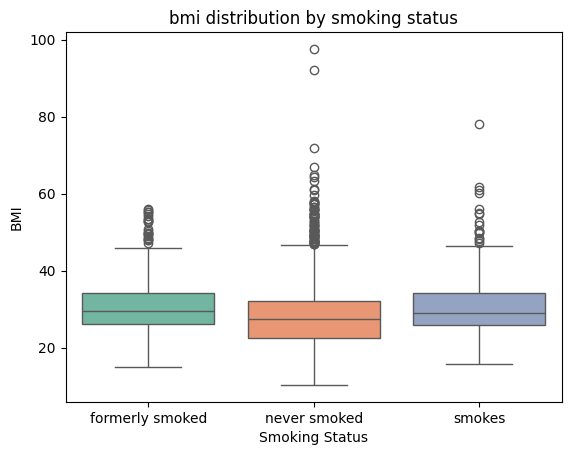

p_value is:  5.1484035730120197e-26


In [ ]:
#visualize bmi by smoking status
sns.boxplot(x = 'smoking_status', y = 'bmi', data = df, palette= 'Set2')
plt.title('bmi distribution by smoking status')
plt.xlabel('Smoking Status')
plt.ylabel('BMI')
plt.show()

#group bmi by different smoking status
never_smoked = df[df['smoking_status'] == 'never smoked']['bmi']
formerly_smoked= df[df['smoking_status'] == 'formerly smoked']['bmi']
smokes = df[df['smoking_status'] == 'smokes']['bmi']

#anova testy
f_statistic, p_value = stats.f_oneway(never_smoked, formerly_smoked, smokes)

print('p_value is: ', p_value)

> Since our p-value printed above is less than alpha = 0.05, we reject the null hypothesis and conclude that there is a significant difference in the mean bmi between the different groups regarding smoking status as shown by our ANOVA test.

##**Correlation Matrix**

We will now create a correlation matrix to determine the correlations between different numerical variables in the dataset.
Our approach here is to make sure that we treat binary numerical data appropriately when adding it to the correlation matrix and determing the pearson correlation coefficient through the use of pointbiserialr from scipy.

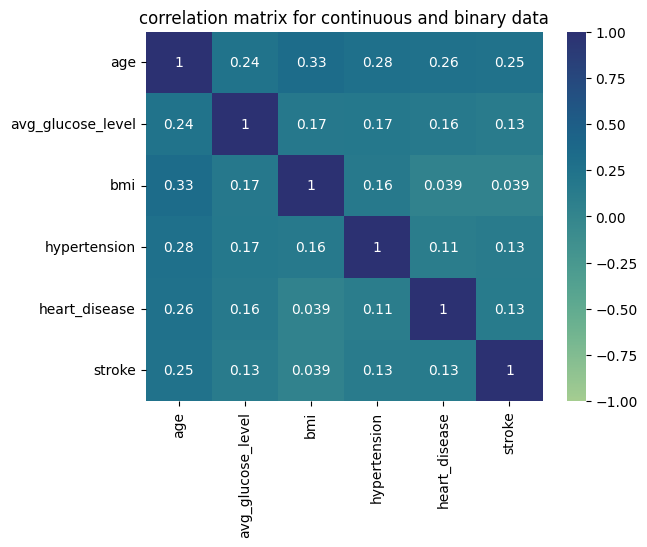

In [ ]:
columns = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease', 'stroke']
correlation_matrix = pd.DataFrame(index=columns, columns=columns)

for col1 in columns:
    for col2 in columns:
        #both columns continuous
        if col1 in ['age', 'avg_glucose_level', 'bmi'] and col2 in ['age', 'avg_glucose_level', 'bmi']:
            correlation = df[col1].corr(df[col2])
        #binary and continuous column
        elif (col1 in ['hypertension', 'heart_disease', 'stroke'] or col2 in ['hypertension', 'heart_disease', 'stroke']):
            binary_col, continuous_col = (col1, col2) if col1 in ['hypertension', 'heart_disease', 'stroke'] else (col2, col1)
            correlation, _ = pointbiserialr(df[continuous_col], df[binary_col])
        #both binary columns
        else:
            correlation = df[col1].corr(df[col2])
        correlation_matrix.loc[col1, col2] = correlation

correlation_matrix = correlation_matrix.astype(float)
sns.heatmap(correlation_matrix, annot = True, cmap = 'crest', vmin = -1)
plt.title('correlation matrix for continuous and binary data')
plt.show()

Some initial observations from the heatmap:

> None of the variables have correlations above 0.5, meaning that these features, on their own, may not be strong predictors of stroke.

> Age has the strongest positive correlation with stroke, followed by hypertension, avg_glucose_level, and heart disease.

> Bmi shows minimal correlation with stroke, suggesting it plays a less significant role in isolation.

> Age also seems to have the strongest correlation with all the other variables compared to the correlation of any other two variables.



# **Primary Analysis**

##**Walkthrough Of Our Code And Thought Process**

###**Choosing our ML Technique**
**Primary Analysis**
> Based on our EDA and the statistical tests (for example our chi squared test) that we conducted, we saw various associations between variables and stroke occurrence. Some of these include age, hypertension, smoking status.

> To answer the questions posed in the introduction, we determined that a classification machine learning model would be appropriate.

**Why We Chose Classification**
> We chose classification because our target variable (stroke) is a binary variable where 0 stands for no stroke and 1 stands for stroke, which inherently makes our problem a classification problem. So, we will aim to predict whether a patient will have a stroke based on their features.

**Considerations in Algorithm Selection**

> In our dataset, there is a data imbalance as strokes are rare, specifically a ~4.9% occurrence. We have addressed this balance in our code to prevent a biased model.

> Our dataset contains both numerical and categorical variables, which we have also addressed using preprocessing steps such as encoding and scaling.

**Selected Algorithm**

> We chose logistic regression as our algorithm of choice as it provides easily interpretable coefficients while also working extremely well with linearly separable data. Logistic regression is also is extremely common in binary classifciation problems, making it a viable choice to use in our scenario.

###**Machine Learning Algorithm Design and Development**
**Data Preprocessing**

> Regarding the categorical variables, we did label encoding for binary categories such as ever_married in our code and one-hot encoding for categorical variables with more than two categories such as smoking_status and work_type.


> For numerical variables such as age and bmi, we applied the StandardScaler to standardize their ranges.

**Addressing Class Imbalance**

>To address the class imbalance mentioned earlier, we oversampled the minority class using methods such as SMOTE (SMOTE refers to Synthetic Minority Over-sampling Technique). SMOTE will interpolate between existing samples of the minority class, which effectively increase the minority class size.

> We also took advantage of setting the class_weight = balanced in our logistic regression to automatically calculate weights inversely proportional to the class frequencies in the dataset to help the model pay more attention to the minority class. We did this in addition to SMOTE as the dataset still would contain subtle imbalances if we didn't take advantage of this parameter.



**Feature Selection**

 > We looked at the correlation analysis and relevant statistical tests, and chose features that most significantly contributes to stroke prediction, which we'll share below:

> Using our statistical tests, we concluded that smoking and BMI were both significant predictors of stroke, and concluded they were both top choices for relevant features. At the end of all our correlation analysis, we created a heatmap which indicated several potential features. Age, hypertension, average glucose levels, and having previous instances of heart disease were all features we decided were well-associated enough to be included features.

**Splitting the Dataset**

> During our data processing, we considered how we wanted to split the dataset up. Because of the sheer size of the dataset, and the relative simplicity of how we wanted to develop our model, we decided to stick with the train-test split to split our dataset, which will be discussed further later. Below is a short description of each of the two splitting methods we considered, and how we would have implemented each had we used either one.

> **Train-Test Split:** In a train-test split, we split the data into training and testing sets – for instance, we would devote 80% of the dataset toward training and 20% toward testing. We would import the scikit-learn library and use the train_test_split function to split the data, being fully implemented for us already. If we understood how we wanted to split up the values in the dataset, we had sufficient information to make the split.

> **Cross-Validation:** Cross-validation was a second option for our test-splitting method.  We eventually decided not to use this method, but did consider it for a while, since it offered a far more complex way of developing the data. However, per similar reasoning, we determined that the complexity of the splitting method was too excessive for our purposes. Since we only needed to model the relationship and determine relevant factors, we did not need the slower, repeated training required of cross-validation. We did, however, choose to implement stratified K-fold Cross-Validation to maintain the proportion of classes in each fold. After some deliberation, we concluded that using a train-test split would be far more appropriate. To begin with, our dataset is rather large. There were several swaths of unnecessary data, meaning that it would be easier to use the train-test split on our dataset. Since we were only seeking out a model, and no need to retrain several times, as we would do in a cross-validation, which would increase the time taken to do it, as well as the complexity of the actual task.

**Model Training**

> We settled on using a **logistic regression** to model our dataset and correlation between our features and how it would affect our stroke prediction analysis. We decided to train with the trait class_weight set to ‘balanced’, to fix imbalances in our dataset. The regression would take several of the features we filtered out early and set it against the actual datapoints represented by our dataset, to determine the best fits between our dataset and relevant features.

**Model Evaluation Metrics**
> **Confusion Matrix:** Provides insight into true positives, false positives, true negatives, and false negatives. We used a confusion matrix, which yielded values representing true positives, false positives, true negatives, and false negatives. Using this information, we could get a rough idea of how well our chosen features correlated with being an actual stroke predictor. We had a very high proportion of true positives, which was valuable, knowing that our features were chosen well. Both our false positive and true negative numbers were rather low – however, we had a huge number of false negatives. In other words, situations where we improperly labeled someone as not susceptible to stroke, when they have a stroke. We were slightly apprehensive, since in the situation of stroke prediction, we would much rather have false positives than false negatives, since falsely predicting a stroke when a stroke did not happen helps us far more. However, we decided that the proportion of true positives compared to all our other values was high enough that it was negligible in our analysis.

> **Classification Report:** Our classification report yielded some important findings about the dataset. We had an imbalanced dataset – as indicated by class 1 being the minority. This meaning, our model struggles to predict stroke very accurately, with a low precision of 0.13. There was also something of a trade-off between classes. Our model prioritized detecting class 1, having a high recall of 0.79, but very often misclassified class 0 as class 1. Our ROC-AUC score was somewhat good at 0.841, indicating that our model did well at distinguishing between classes – although not reflecting the poor precision for the minority class. Based on the results of our classification report, we deduced that we should address the class imbalances by using over or under sampling, or readjusting the class weights, as well as putting more focus on improving precision for the minority class without sacrificing recall at the same time.




In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE


X = df.drop('stroke', axis=1)
y = df['stroke']

categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numerical_cols = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:,1]

conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', conf_matrix)

class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

roc_auc = roc_auc_score(y_test, y_pred_proba)
print('ROC-AUC Score:', roc_auc)


Confusion Matrix:
 [[886 330]
 [ 13  49]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.73      0.84      1216
           1       0.13      0.79      0.22        62

    accuracy                           0.73      1278
   macro avg       0.56      0.76      0.53      1278
weighted avg       0.94      0.73      0.81      1278

ROC-AUC Score: 0.8412696307300509


#**Visualization Of The Model**

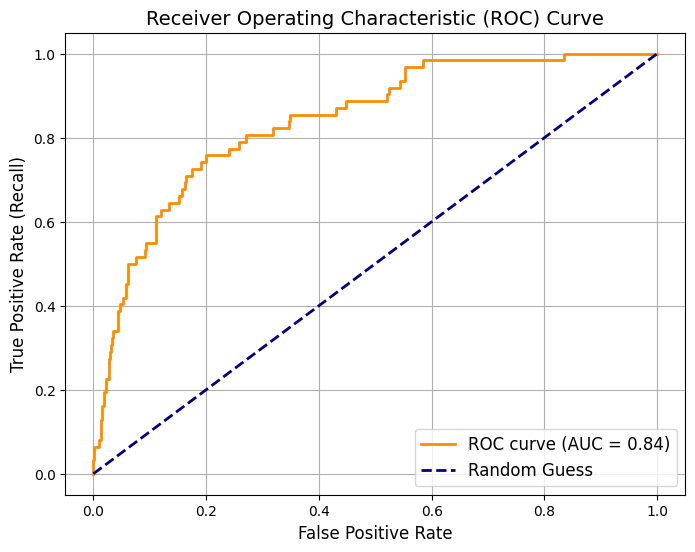

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.show()

**ROC Curve Explanation**
> The x-axis of the ROC curve plot represents the proportion of actual negatives that are incorrectly classfiied by the model as positives and the y-axis of the ROC curve plot represents the proportion of actual positives correctly identified. Lastly, the AUC (Area Under Curve) in the legend represents the model's ability to distinguish between classes where an AUC of 1 indicates perfect ability to distinguish, while an AUC of 0.5 represents no ability to distinguish. Based on our AUC of 0.84, we can confidently say our model has good performance in terms of being able to distinguish between classes. Basically, we can say that approximately 84% of the time, our model can correctly differentiate between the two classes. 

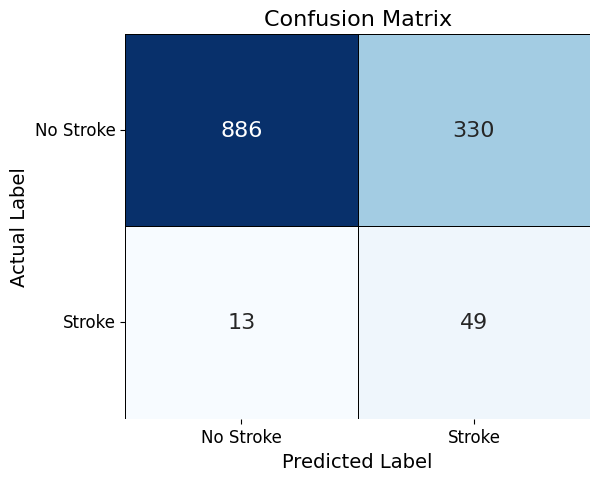

In [ ]:
import seaborn as sns
import numpy as np

conf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['No Stroke', 'Stroke']

conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 16}, linewidths=0.5, linecolor='black')

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.show()

**Confusion Matrix Explanation**
> A confusion matrix essentially just provides a summary of prediction results on a classification problem. It is able to show the count of correct and incorrect predictions for each class. Based on our confusion matrix, we are able to see that we have 886 True Positives, 330 False Positives, 49 True Negatives, and 13 False Negatives. Based on these results, we can see that our model has a high number of True Positives and False Positives. In our scenario, it is better to have more False Positives than False Negatives as we would rather accidentally classify someone as being at a high risk of stroke (even if they may not be) so that they can take proper precautions rather than classify someone as not being at a high risk of stroke (if they actually are). To put this in proper terms, in our healthcare context we would much rather have a higher recall even if it means that we will have more false positives and in our case, we have 79% recall which shows our model is effective at identifying stroke cases. 

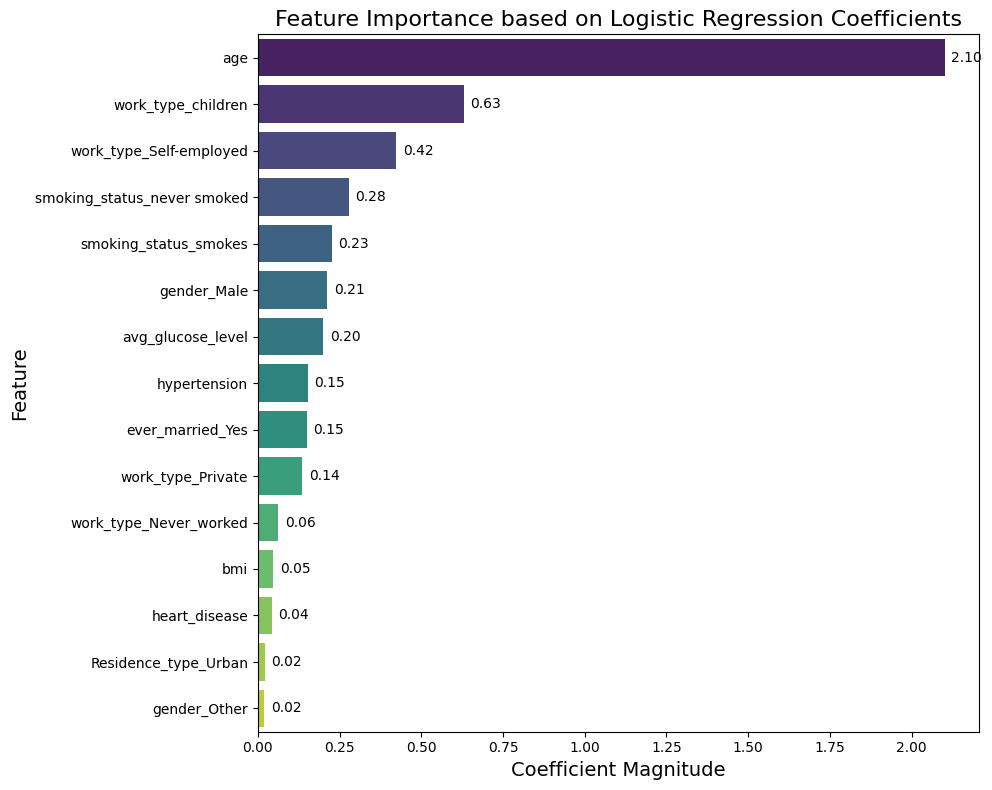

In [ ]:
feature_names = numerical_cols + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols))

coefficients = pipeline.named_steps['classifier'].coef_[0]

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

feature_importance['Absolute Coefficient'] = feature_importance['Coefficient'].abs()

feature_importance.sort_values(by='Absolute Coefficient', ascending=False, inplace=True)

plt.figure(figsize=(10, 8))
ax = sns.barplot(x='Absolute Coefficient', y='Feature', data=feature_importance, palette='viridis')

for i, value in enumerate(feature_importance['Absolute Coefficient']):
    ax.text(value + 0.02, i, f'{value:.2f}', va='center', fontsize=10)

plt.title('Feature Importance based on Logistic Regression Coefficients', fontsize=16)
plt.xlabel('Coefficient Magnitude', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

**Feature Importance Plot Explanation**
> Our Feature Importance Plot is effective in helping us understand which features contribute most to the model's prediction. In logistic regression, we can utilize the coefficients to gauge feature importance. A positive coefficient will indicate that a certain feature will increase the likelihood of predicting a stroke and a negative coefficient will indicate that a cetain feature will decrease the likelihood of predictive a stroke. Lastly, the magnitude of the coefficient will indicate the strength of the feature's impact. Based on our chart, we are able to see that age, work_type being children, and work_type being Self_Employed were the top 3 in terms of having a positive impact on stroke risk. We are able to then see that age's coefficient of 2.10 significantly larger than any other factor, indicating that strokes are more common in older individuals. 